Housekeeping

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,endword=None,index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == "Total":
            break
        elif len(words)>1 and results_follow==1:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))

In [3]:
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)

In [4]:
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

In [5]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

<a id='index'></a>


## Quantile regressions for tenure

### Women

Jump to
 - [Men](#urgh)
 --------------

In [6]:
path = './results/'

file_split('sqtreg_mothers_3545.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'sqtreg_mothers_45_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_50 = read_table(path+'sqtreg_mothers_45_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_75 = read_table(path+'sqtreg_mothers_45_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

descrip_stats = pd.read_stata('parents_dataset_spain.dta')


coef_50_m_45 = tab_moms_45_50['Coefficient']
coef_25_m_45 = tab_moms_45_25['Coefficient']
coef_75_m_45 = tab_moms_45_75['Coefficient']

In [7]:
def predicted_ten_women(coef_series,descriptive_table,ten_range,age_at_mean=None,
                        educ=None,part_time=False,hub_educ=None):
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    av_age_da_05 = descriptive_table['Age_father'][0]
    b_ten_hub = coef_series.loc['hub_ten_y']
    b_ten2_hub = coef_series.loc['hub_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['hub_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['hub_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
    predicted_ten =  coef_series.loc['_cons'] + \
            coef_series.loc['edad5']*av_age_mo_05 + coef_series.loc['hub_age']*av_age_da_05 + \
            ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

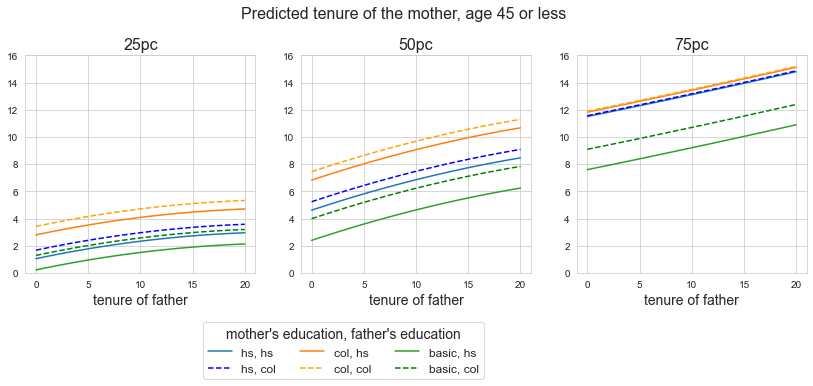

In [8]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, age 45 or less',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of father',fontsize=14)
plt.legend(title="mother's education, father's education",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
# plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_all_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [9]:
path = './results/'

file_split('sqtreg_mothers_0k_3545.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'sqtreg_mothers_0k_45_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'sqtreg_mothers_0k_45_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'sqtreg_mothers_0k_45_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_m_45_0k = tab_moms_45_50_0k['Coefficient']
coef_25_m_45_0k = tab_moms_45_25_0k['Coefficient']
coef_75_m_45_0k = tab_moms_45_75_0k['Coefficient']

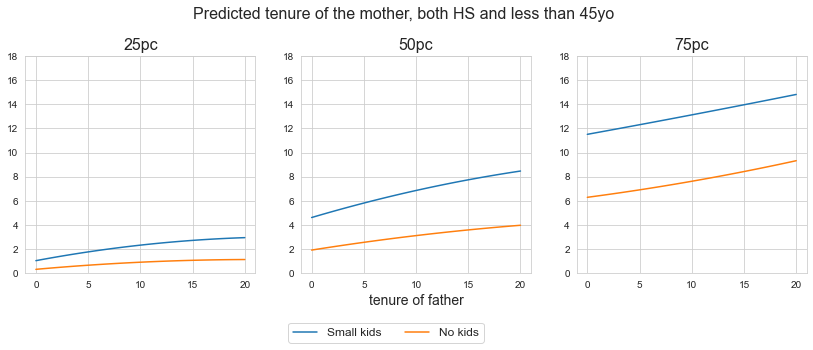

In [10]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range),label='No kids')
# plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,18)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,18)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range),label='No kids')
plt.ylim(0,18)

plt.savefig('./plots_tenure/qregs_spa_HS_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

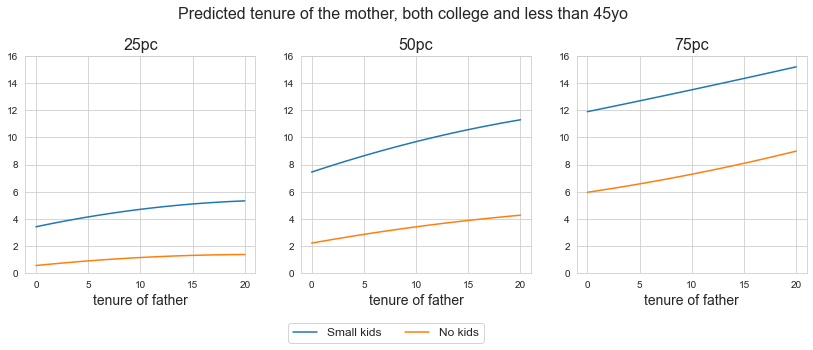

In [11]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

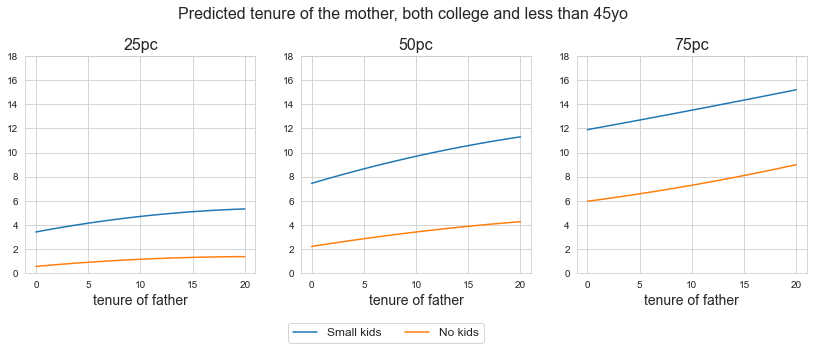

In [13]:
ten_range = np.linspace(0,20,100)
age_mean = descrip_stats['Age_mother'][0]

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,18)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,18)
plt.xlabel('tenure of father',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range,age_at_mean=age_mean
                                       ,educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,18)
plt.xlabel('tenure of father',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_3545_sameage.pdf',format='pdf',bbox_inches='tight')
plt.show()

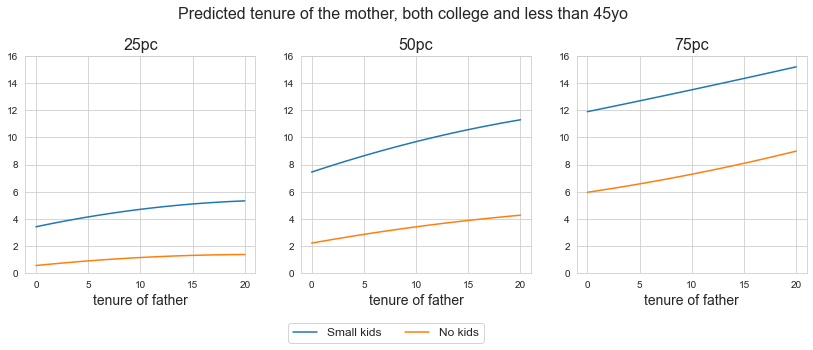

In [14]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [18]:
sd_50_m_45_0k = tab_moms_45_50_0k['std']
sd_50_m_45 = tab_moms_45_50['std']

sd_25_m_45_0k = tab_moms_45_25_0k['std']
sd_25_m_45 = tab_moms_45_25['std']

sd_75_m_45_0k = tab_moms_45_75_0k['std']
sd_75_m_45 = tab_moms_45_75['std']

In [21]:
bnames = coef_50_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['35-45, With kids','35-45, No kids']

data_0k_45 = np.empty(N*2)
data_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_0k_45[i] = coef_50_m_45_0k.loc[name]
    data_45[i] = coef_50_m_45.loc[name]
    i+=1
    data_0k_45[i] = sd_50_m_45_0k.loc[name]
    data_45[i] = sd_50_m_45.loc[name]
    i+=1
    
coef_table_export = pd.DataFrame(np.vstack((data_45,data_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export.iloc[i,0]='('+str(coef_table_export.iloc[i,0])+')'
    coef_table_export.iloc[i,1]='('+str(coef_table_export.iloc[i,1])+')'
#     coef_table_export.iloc[i,2]='('+str(coef_table_export.iloc[i,2])+')'

In [22]:
print(coef_table_export.to_latex())

\begin{tabular}{lll}
\toprule
{} & 35-45, With kids & 35-45, No kids \\
\midrule
husband tenure         &            0.255 &          0.137 \\
                       &          (0.006) &        (0.008) \\
husband tenure 2       &           -0.003 &         -0.002 \\
                       &            (0.0) &          (0.0) \\
age                    &            0.338 &          0.182 \\
                       &          (0.005) &        (0.003) \\
part-time              &           -1.869 &         -1.058 \\
                       &          (0.039) &        (0.026) \\
college                &            2.211 &          0.345 \\
                       &          (0.035) &        (0.034) \\
less than HS           &           -1.247 &         -0.595 \\
                       &          (0.069) &        (0.067) \\
husband's age          &           -0.014 &         -0.001 \\
                       &          (0.004) &        (0.002) \\
husband is SE          &            0.118 &        

In [23]:
bnames = coef_25_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['Less than 45, With kids','Less than 45, No kids']

data_25_0k_45 = np.empty(N*2)
data_25_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_25_0k_45[i] = coef_25_m_45_0k.loc[name]
    data_25_45[i] = coef_25_m_45.loc[name]
    i+=1
    data_25_0k_45[i] = sd_25_m_45_0k.loc[name]
    data_25_45[i] = sd_25_m_45.loc[name]
    i+=1
    
coef_table_export_25 = pd.DataFrame(np.vstack((data_25_45,data_25_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export_25.iloc[i,0]='('+str(coef_table_export_25.iloc[i,0])+')'
    coef_table_export_25.iloc[i,1]='('+str(coef_table_export_25.iloc[i,1])+')'

In [24]:
print(coef_table_export_25.to_latex())

\begin{tabular}{lll}
\toprule
{} & Less than 45, With kids & Less than 45, No kids \\
\midrule
husband tenure         &                   0.162 &                 0.077 \\
                       &                 (0.005) &               (0.003) \\
husband tenure 2       &                  -0.003 &                -0.002 \\
                       &                   (0.0) &                 (0.0) \\
age                    &                   0.117 &                 0.068 \\
                       &                 (0.003) &               (0.002) \\
part-time              &                  -1.175 &                -0.517 \\
                       &                 (0.024) &               (0.016) \\
college                &                   1.751 &                 0.271 \\
                       &                 (0.026) &               (0.026) \\
less than HS           &                  -0.383 &                -0.223 \\
                       &                 (0.025) &               (0.0

In [25]:
bnames = coef_75_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['35-45, With kids','35-45, No kids']

data_75_0k_45 = np.empty(N*2)
data_75_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_75_0k_45[i] = coef_75_m_45_0k.loc[name]
    data_75_45[i] = coef_75_m_45.loc[name]
    i+=1
    data_75_0k_45[i] = sd_75_m_45_0k.loc[name]
    data_75_45[i] = sd_75_m_45.loc[name]
    i+=1
    
coef_table_export_75 = pd.DataFrame(np.vstack((data_75_45,data_75_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export_75.iloc[i,0]='('+str(coef_table_export_75.iloc[i,0])+')'
    coef_table_export_75.iloc[i,1]='('+str(coef_table_export_75.iloc[i,1])+')'


In [26]:
print(coef_table_export_75.to_latex())

\begin{tabular}{lll}
\toprule
{} & 35-45, With kids & 35-45, No kids \\
\midrule
husband tenure         &            0.157 &          0.114 \\
                       &          (0.006) &        (0.009) \\
husband tenure 2       &                0 &          0.002 \\
                       &            (0.0) &          (0.0) \\
age                    &            0.578 &          0.389 \\
                       &          (0.004) &        (0.005) \\
part-time              &           -1.418 &         -1.534 \\
                       &          (0.029) &        (0.048) \\
college                &            0.324 &         -0.054 \\
                       &          (0.032) &        (0.046) \\
less than HS           &           -2.474 &         -0.884 \\
                       &          (0.117) &        (0.104) \\
husband's age          &            0.044 &          0.017 \\
                       &          (0.004) &        (0.004) \\
husband is SE          &            0.176 &        

In [27]:
print(tab_moms_45_25_0k.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &   std &       t &  p\_stat &  lower\_95 &  upper\_95q25 \\
\midrule
hub\_ten\_y   &        0.077 & 0.003 &  23.310 &   0.000 &     0.071 &        0.084 \\
hub\_ten\_y2  &       -0.002 & 0.000 & -12.510 &   0.000 &    -0.002 &       -0.002 \\
edad5       &        0.068 & 0.002 &  28.530 &   0.000 &     0.063 &        0.072 \\
pc\_dummy    &        2.285 & 0.016 & 138.620 &   0.000 &     2.252 &        2.317 \\
part\_time   &       -0.517 & 0.016 & -32.930 &   0.000 &    -0.547 &       -0.486 \\
college     &        0.271 & 0.026 &  10.440 &   0.000 &     0.220 &        0.322 \\
less\_hs     &       -0.223 & 0.039 &  -5.770 &   0.000 &    -0.299 &       -0.147 \\
hub\_age     &       -0.003 & 0.002 &  -1.640 &   0.102 &    -0.008 &        0.001 \\
hub\_se      &       -0.077 & 0.025 &  -3.080 &   0.002 &    -0.126 &       -0.028 \\
hub\_college &       -0.029 & 0.017 &  -1.640 &   0.101 &    -0.063 &        0.006 \\
hub\_less\_hs &   

<a id='urgh'></a>

### Men

Jump to
 - [Women](#index)
 --------------

In [28]:
def predicted_ten_men(coef_series,descriptive_table,ten_range,age_at_mean=None,
                      educ=None,part_time=False,hub_educ=None):
    av_age_da_05 = descriptive_table['Age_father'][0]
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    b_ten_hub = coef_series.loc['wife_ten_y']
    b_ten2_hub = coef_series.loc['wife_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['wife_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['wife_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
    predicted_ten =  coef_series.loc['_cons'] + \
            coef_series.loc['edad5']*av_age_da_05 + coef_series.loc['wife_age']*av_age_mo_05 + \
            ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

In [29]:
path = './results/'

file_split('sqtreg_fathers_0k_3545.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+'sqtreg_fathers_0k_45_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_50_0k = read_table(path+'sqtreg_fathers_0k_45_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_75_0k = read_table(path+'sqtreg_fathers_0k_45_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_d_45_0k = tab_dads_45_50_0k['Coefficient']
coef_25_d_45_0k = tab_dads_45_25_0k['Coefficient']
coef_75_d_45_0k = tab_dads_45_75_0k['Coefficient']


file_split('sqtreg_fathers_45.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+'sqtreg_fathers_45_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_50 = read_table(path+'sqtreg_fathers_45_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_75 = read_table(path+'sqtreg_fathers_45_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_d_45 = tab_dads_45_50['Coefficient']
coef_25_d_45 = tab_dads_45_25['Coefficient']
coef_75_d_45 = tab_dads_45_75['Coefficient']

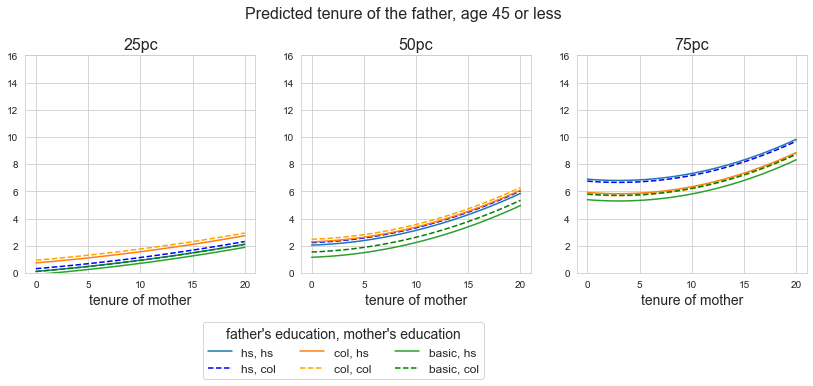

In [30]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, age 45 or less',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of mother',fontsize=14)
plt.legend(title="father's education, mother's education",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
# plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_all_dads_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

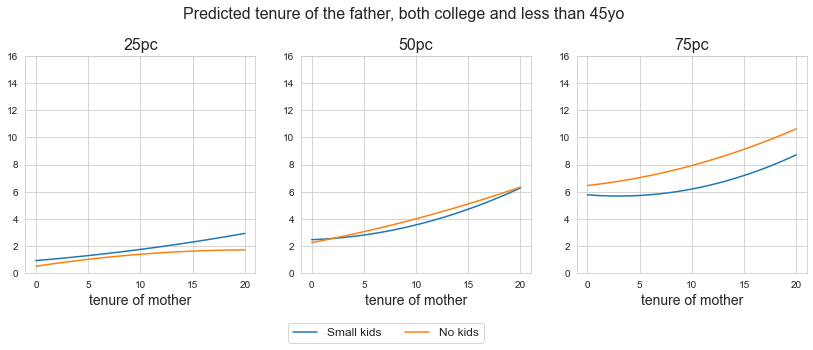

In [31]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_dads_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

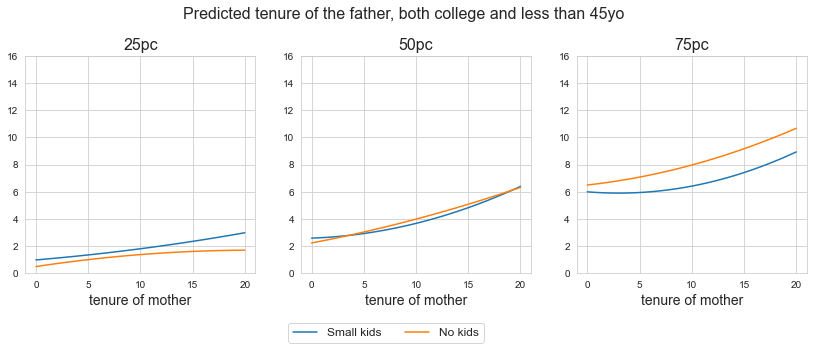

In [32]:
ten_range = np.linspace(0,20,100)
age_mean = descrip_stats['Age_father'][0]

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,age_at_mean=age_mean,
                                     educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range,age_at_mean=age_mean
                                     ,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,age_at_mean=age_mean,
                                     educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range,age_at_mean=age_mean,
                                     educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,age_at_mean=age_mean,
                                     educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range,age_at_mean=age_mean,
                                     educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_dads_3545_sameage.pdf',format='pdf',bbox_inches='tight')
plt.show()

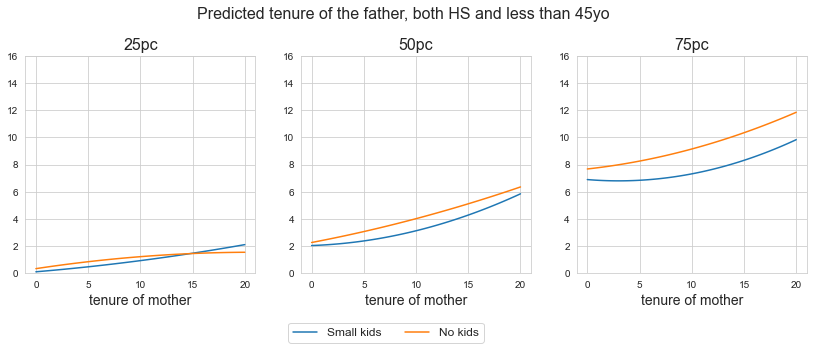

In [33]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both HS and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_HS_dads_3545.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [34]:
descrip_stats

,index,Tenure_mother,Tenure_father,Tenure_mother_PC,Tenure_father_PC,Participation_mother,Participation_father,Employment_mother,Employment_father,Unemployment_mother,Unemployment_father,Age_mother,Age_father,Hours_mother,Hours_father,dates
0,130,91.09012,116.9287,127.9036,141.4162,0.633599,0.961774,0.450439,0.709365,0.147943,0.044601,35.20958,37.41877,28.671940,38.063430,2005Q1
1,131,89.06780,115.4223,126.7102,143.1194,0.635941,0.963031,0.462568,0.724105,0.129352,0.036813,35.20274,37.49490,29.851419,40.176169,2005Q2
2,132,89.37599,114.5817,125.6732,140.4082,0.633274,0.960994,0.469644,0.723078,0.115090,0.038163,35.21030,37.48182,28.971241,38.834750,2005Q3
3,133,90.05831,114.4557,129.0288,141.2429,0.649908,0.961877,0.478113,0.719393,0.125371,0.037142,35.22358,37.49816,29.290787,39.165262,2005Q4
4,134,91.16219,116.4211,130.2905,146.4587,0.659418,0.962015,0.483887,0.715218,0.130488,0.039579,35.29366,37.62405,29.797640,39.625940,2006Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,193,111.58080,125.1961,139.5246,146.7777,0.812523,0.954835,0.587577,0.705015,0.180266,0.078425,38.19639,40.31597,29.603744,36.326162,2020Q4
64,194,116.03410,131.8757,139.5533,149.7803,0.814278,0.949276,0.588652,0.699881,0.176658,0.080463,38.55468,40.47890,27.780260,34.619440,2021Q1
65,195,113.27630,128.4572,138.7459,146.1301,0.821331,0.957396,0.599467,0.712823,0.164208,0.070140,38.59576,40.54585,31.130821,38.005726,2021Q2
66,196,112.86080,128.3862,139.8803,146.5570,0.817427,0.959945,0.605297,0.714653,0.152793,0.077505,38.72406,40.67633,28.817812,34.794831,2021Q3
